# Abstract

This paper explores AXC’s instantaneous liquidity framework as an optimization problem to achieve capital efficiency across various scenarios. Monte Carlo simulations have been developed to analyze the trade-off between opportunity cost and tradability. Based on our simulated models, implementing AXC’s framework will enhance tradability by minimizing slippage and price impact, while reducing the variation between the value of the RWA’s vault token in the decentralized on-chain environment and the net asset value (NAV) of the underlying asset. Nevertheless, capital is required in order to implement this framework, and this capital has its opportunity cost. The findings from the simulation model will serve as an parameter optimization methodology in guiding AXC's strategic scenario planning.


# Introduction


The AXC framework is designed to deliver instantaneous liquidity for Real World Assets (RWA) tokens by utilizing decentralized exchanges (DEX) like Uniswap, which operate on the "constant product" formula $x*y=k$. This liquidity framework is supported by three main streams of external funding, described as follows:

* **Stream A** (Liquidity Reserve): A portion of the proceeds from RWA vaults is used to enable users to become liquidity providers (LPs) by depositing equivalent values of each underlying token in the RWA pool to increase liquidity depth.
* **Stream B** (Market Making Bot): An AXC-operated arbitrage market-making bot engages in automatic trading of RWA vault tokens on the DEX. This bot aims to align the DEX's market value with the Net Asset Value, thereby enhancing price discovery and ensuring reliable counterparty liquidity.
* **Stream C** (Liquidity Reserve): The governance token staking vault serves as an liquidity providers (LPs) by depositing equivalent values of each underlying token in the RWA pool to increase liquidity depth. These pool tokens represent pro-rata shares of the total reserves and can be redeemed for the underlying assets at any time.

The integration of these streams ensures that liquidity is consistently maintained through a reserve liquidity pool, complemented by an arbitrage market-making bot. This strategic approach facilitates robust liquidity management for RWA tokens on decentralized platforms.

The backtesting below will demonstrate the effectiveness of this mechanism. Four scenarios and simulations will be conducted using the framework. Each scenario in this Monte Carlo simulation explores the optimization problem from a different market microstructure perspective. The code for these simulations is BSD-licensed and available at https://github.com/accelerate-protocol/axc-backtesting . The version of Uniswappy used for these simulations, which includes modifications to the original version, can be found at https://github.com/hkphysics/uniswappy. The models and code are designed to perform calculations with simulated data. Empirical data will be included in future versions of this paper to provide a more quantitatively realistic model.   

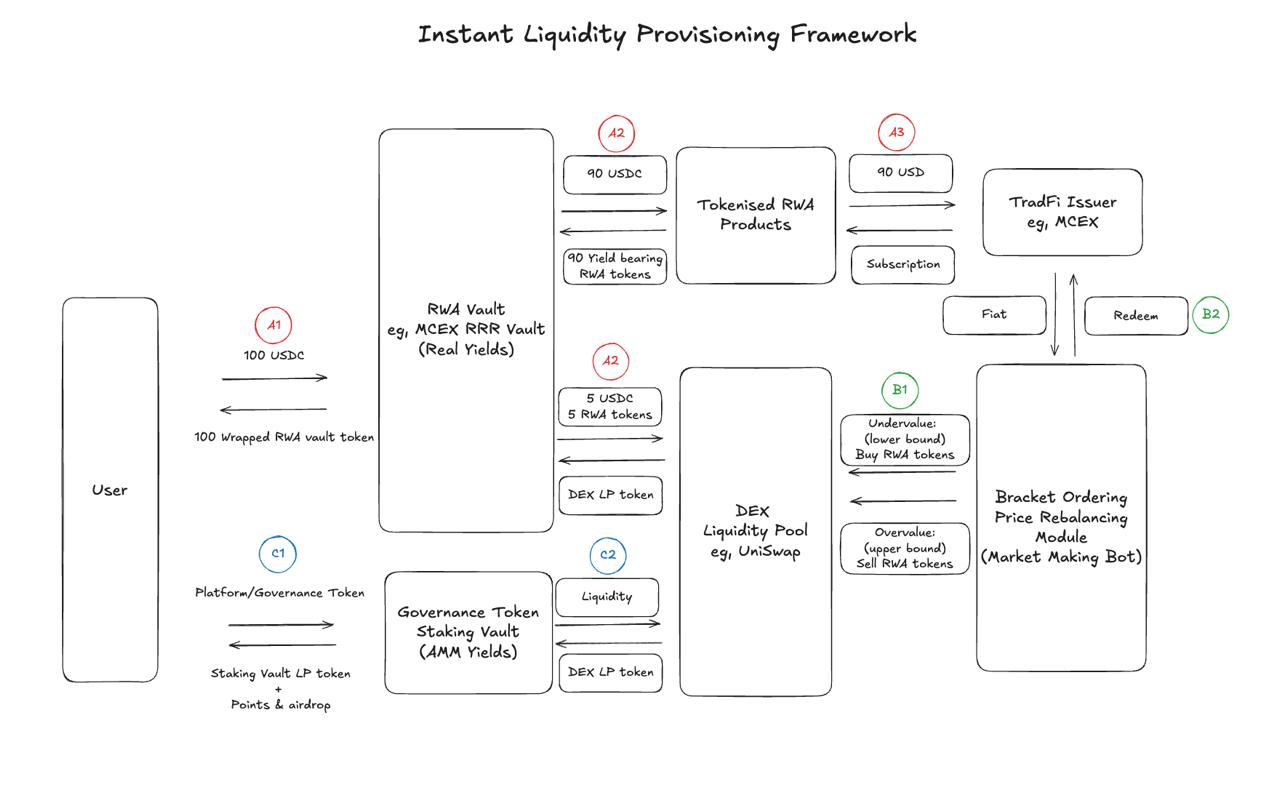


## Model parameters

### Liquidity reserve assumptions

The assumptions for the calculations below are as follows: The user pool holds 10,000 USDT, while the reserve pool contains 50,000 USDT, concentrated between 0.9 and 1.0.
These calculations demonstrate the impact of large trades on the DEX, both with and without the liquidity reserve. According to the results, the price will drop much more severely without the liquidity reserve.

### Arbitrage market making bot algorithm

The bot operates based on two core conditions, ensuring that expected profits cover transaction costs $C_{tx}$, slippage $S$, and potential redemption/minting costs $C_{mgt}$.

**Condition 1** TKN is Undervalued (Buy TKN)

- When the price $P$ on the DEX is significantly lower than underlying value $V$.
  - Action: The bot buys TKN
  - Profit Realization: Convert and redeem TKN for underlying asset to capture its intrinsic value and accrued interest. Hold TKN, anticipating its market price $P$ will converge upwards towards $V$, then sell, also benefiting from underlying asset underlying appreciation.


**Condition 2** TKN is Overvalued (Sell TKN)

- When price $P$ on the DEX is significantly higher than underlying value $V$
  - Action: The bot sells its existing TKN holdings or newly minted TKN.
  - Profit Realization: Directly capture the spread between the USDC received from selling TKN and the value of underlying asset (plus any minting costs).

The key decision parameters are
* $P$: Real-time DEX price.
* $V$: Current intrinsic value of underlying (including accrued yield), obtained via API
* $C_{tx}$ Transaction costs, $S$ slippage tolerances and $R$ redemption thresholds.
* Specifics of the underlying redemption/dividend mechanism and the TKN minting process.

For this y, the bot is initialized with 10000 USDT and 10000 tokens.  If the price difference between the DEX price $P$ and the underlying price $V$ exceeds 5 percent, an order will be issued to move $P$ up or down so  that the difference with $V$ is below 2 percent.  

If the amount of cash falls below 5000 USDT, a simulated order will be issued to convert 5000 tokens to USDT via a redemption order to the backend.  To simulate the delay in fulfilling this order, a delay of 50 trades is before the redemption is considered filled.




# Simulation Results

##  Maximum drawdown

The graph below illustrates the impact of a single large sell order on the price prior to the intervention of the market-making arbitrage bot. The model was executed with various large sell orders against the baseline liquidity, both with and without a liquidity reserve. The incorporation of a liquidity reserve significantly mitigates the price impact of large swaps, due primarily to the Uniswap v3 liquidity concentration mechanism, which enables tokens from the liquidity reserve to be sold at elevated prices. This simulation specifically quantifies the immediate impact of a single large order before the intervention of the arbitrage market-making bot.



In [ ]:
from axc_lp import *

tenv = token_scenario_baseline

In [ ]:
results = do_calc2(
    tenv,
    [
        [[tenv.user_lp, "min_tick", "max_tick"]],
        [
            [tenv.user_lp, "min_tick", "max_tick"],
            [tenv.reserve, tenv.reserve_lower, tenv.nav],
        ],
    ],
    ["baseline", "baseline with reserve"],
)
plotme(
    results,
    "",
    title="Price impact of single large token sale",
)

In this scenario, there is a single large order in which the market has no time to react.  The addition of a liquidity pool substantially decreases the price impact of a large order.  The liquidity reserve creates a pool of tokens which are sold near NAV price due to the use of the Uniswap V3 concentrated liquidity mechanism.  Although the large order will consume all of the tokens in the concentrated liquidity pool, the fact that all of the tokens in the liquidity reserve  are sold near NAV forces the final price to remain high.

This simulation shows that a liquidity pool can limit the price impact of a single large order.  Although it may be possible for a series of multiple orders to push down the price, we expect that the price impact in those cases  will be limited as our arbitrage bot and other user orders will push up the price after an initial shock.

## Monte carlo scenario simulations

To demonstrate the functionality of the liquidity reserve and market maker arbitrage bot
four scenarios were run with runs of 500 trades and 50 paths per scenario.  The NAV
of was set at 1 USDT per TKN.  The typical size of a trade is 1000 USDT and was simulated using
a gamma distribution with shape parameter of 1 and a scale parameter of 1000 USDT with buys
and sells occurring with equal probability.


In [ ]:
from axc_lp import run_paths

results = run_paths(tenv)

**Scenario 1** (Baseline scenario)
  - Assumes total liquidity from the users is 10,000 USDT without using Uniswap V3 concentrated liquidity feature



In [ ]:
%matplotlib ipympl

plot_distribution(results[0].price, "Scenario 1")

Scenario 1 illustrates large price variation against NAV and slippage before implmenting AXC's  liquidity framework. 

**Scenario 2** (Baseline + Liquidity reserve)
  - Liquidity Reserve from Stream A and Stream C: 50,000 USDT

In [ ]:
plot_distribution(results[1].price, "Scenario 2")

Scenario 2 illustrates the impact of including only the liquidity reserve. The liquidity reserve sets the NAV as a lower bound, but there is still substantial price variation above NAV.

**Scenario 3** (Baseline + Arbitrage bot)
- MM Bot Liquidity: 10,000 RWA Tokens, 10,000 USDT.
- The MM Bot intervenes when the price deviates from the NAV by 5%, aiming to adjust it back to a 2% deviation.
- The upper and lower bounds of intervention will be optimized depending on the order flow.
- Whenever the USDT balance falls below 5,000, the bot will initiate a redemption process (convert RWA tokens to securities, then to cash).
- The time delay for converting from RWA tokens to cash spans 50 trades.


In [ ]:
plot_distribution(results[2].price, "Scenario 3")

Scenario 3 includes only the arbitrage market-making bot and illustrates that the current algorithm used by the bot reduces price variation, but does not prevent the price from falling below the NAV.

**Scenario 4** (Baseline + liquidity reserve + Arbitrage bot)

In [ ]:
plot_distribution(results[3].price, "Scenario 4")

Scenario 4 is the scenario that most closely resembles how the elements of the liquidity framework would be used in production. The market maker bot and the liquidity reserve establish a lower bound for the price and also reduce variation. These results illustrate that the liquidity mechanism is effective at reducing price slippage while maintaining liquidity.

# Conclusion

The code for these simulation models constitutes a fundamental methodology for optimizing parameters within the framework. Continued research and systematic data collection will be imperative to ascertain the optimal parameters for various RWA vault tokens in the AXC protocol.

Future research will include

- Modeling changes to NAV, which will require modifications to the system so that liquidity reserve are periodically reset to reflect changes in NAV.
- Modeling the evolution of prices over time frequencies rather than over individual trades.
- Measuring all the risks.
- Gathering trade data from actual runs to enhance modeling accuracy.
- Setting parameters to optimize the performance of bots and pools, ensuring maximum liquidity and minimum price slippage for a given amount of capital and risk.
- Measuring the opportunity cost of capital utilized from external funding sources Stream A, B, and C.